# Import Dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.svm import SVC
from Preprocessing_functions import *
from sklearn.model_selection import cross_val_score, train_test_split


In [26]:
train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')
test_data = pd.read_csv('test_data.csv', index_col='Claim Identifier')

C:\Users\inesm\AppData\Local\Temp\ipykernel_27960\3470921380.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')


# Preprocessing

In [29]:
#Split the data into training and validation sets
train_data = train_data[~(train_data.drop(columns=['Assembly Date']).isna().all(axis=1) & train_data['Assembly Date'].notna())] 
X = train_data.drop(columns=['Claim Injury Type', 'WCB Decision', 'Agreement Reached'])
y = train_data['Claim Injury Type']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


In [4]:
CODE_COLUMNS = ['Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']

DESCRIPTION_COLUMNS = ['WCIO Cause of Injury Description','WCIO Nature of Injury Description','WCIO Part Of Body Description','Industry Code Description']

BOOLEAN_COLUMNS = ['Alternative Dispute Resolution', 'Attorney/Representative','COVID-19 Indicator']

date_order = ['Accident Date', 'C-2 Date','C-3 Date','Assembly Date', 'First Hearing Date']


In [5]:
numerical_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year', 
    'C-2 Date', 
    'C-3 Date', 
    'First Hearing Date', 
    'IME-4 Count', 
]

categorical_features = ['Alternative Dispute Resolution',
 'Attorney/Representative',
 'Carrier Name',
 'Carrier Type',
 'County of Injury',
 'COVID-19 Indicator',
 'District Name',
 'Gender',
 'Industry Code',
 'Medical Fee Region',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code']

col_minmax = ['Age at Injury',
               'Birth Year', 
               'Number of Dependents']

col_standart = ['Accident Date',
                'Assembly Date',
                'Average Weekly Wage',
                ]

low_cardinality_cols = [col for col in categorical_features if X_train[col].nunique() < 10]
high_cardinality_cols = [col for col in categorical_features if X_train[col].nunique() > 10]




In [6]:
high_cardinality_cols

['Carrier Name',
 'County of Injury',
 'Industry Code',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code']

In [7]:
X_train[categorical_features] = X_train[categorical_features].astype(str)
X_val[categorical_features] = X_val[categorical_features].astype(str)

In [8]:
def drop_description_columns(X_train, X_val):
    """
    Drop all columns in X_train and X_val that contain the word 'description' in their names (case-insensitive).
    """
    description_columns = X_train.columns[X_train.columns.str.contains('description', case=False, na=False)]
    

    X_train = X_train.drop(description_columns, axis=1)
    X_val = X_val.drop(description_columns, axis=1)
    
    return X_train, X_val

X_train ,X_val = drop_description_columns(X_train, X_val)

In [9]:
def preprocessing_dum(X_train, X_val):
    drop_description_columns(X_train, X_val)
    convert_to_timestamp(X_train, X_val, date_order)
    convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)
    impute_mean_numerical(X_train, X_val, numerical_columns)
    fill_missing_with_mode(X_train, X_val)
    feature_creation_has_Cdate(X_train, X_val)
    # columns_to_drop = ['C-2 Date', 'C-3 Date', 'First Hearing Date']
    # X_train = X_train.drop(columns=columns_to_drop)
    # X_val = X_val.drop(columns=columns_to_drop)


    return X_train, X_val



def scaling_encoding(X_train, X_val):
    scaling_minmax(X_train, X_val, col_minmax)
    scaling_standard(X_train, X_val, col_standart)
    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)


    return X_train, X_val




In [10]:
# def preprocessing(X_train, X_val):

#     X_train=X_train.drop_duplicates()
#     X_val=X_val.drop_duplicates()

#     convert_to_bool(X_train,X_val)
#     #convert to timestamp all columns with Date included in the name
#     #convert_to_timestamp(X_train,X_val,xxxx)
#     #convert_to_datetime(X_train,X_val,xxx)

#     X_train = X_train.drop(columns=['OIICS Nature of Injury Description'])
#     X_val = X_val.drop(columns=['OIICS Nature of Injury Description'])

#     impute_mean_numerical(X_train, X_val, ['C-2 Date'])
#     fillnan_accident_date(X_train,X_val)
#     fillnan_birth_year(X_train,X_val)

#     #drop average weekly wage bc lots of 0 bc fuck it
#     X_train = X_train.drop(columns=['Average Weekly Wage'])
#     X_val = X_val.drop(columns=['Average Weekly Wage'])

#     #fill IME4 Count with 0s 
#     X_train["IME-4 Count"].fillna(0, inplace=True)
#     X_val["IME-4 Count"].fillna(0, inplace=True)

#     X_train['Has First Hearing Date'] = X_train['First Hearing Date'].apply(lambda x: 0 if x == np.nan else 1)
#     X_val['Has First Hearing Date'] = X_val['First Hearing Date'].apply(lambda x: 0 if x == np.nan else 1)

#     # drop first hearing date
#     X_train = X_train.drop(columns=['First Hearing Date'])
#     X_val = X_val.drop(columns=['First Hearing Date'])

#     # creation of 'Has C2 date'
#     X_train['Has C-2 Date'] = X_train['C-2 Date'].apply(lambda x: 0 if pd.isna(x) else 1)
#     X_val['Has C-2 Date'] = X_val['C-2 Date'].apply(lambda x: 0 if pd.isna(x) else 1)
#     impute_mode_categorical(X_train,X_val,['Has C-2 Date'])

#     #codes and stuff
#     fill_missing_codes_description_based(X_train,X_val)
#     fill_missing_with_mode(X_train,X_val)

#     #C3 date
#     X_train['Has C-3 Date'] = X_train['C-3 Date'].apply(lambda x: 0 if pd.isna(x) else 1)
#     X_val['Has C-3 Date'] = X_val['C-3 Date'].apply(lambda x: 0 if pd.isna(x)  else 1)

#     X_train = X_train.drop(columns=['C-3 Date'])
#     X_val = X_val.drop(columns=['C-3 Date'])

#     impute_mode_categorical(X_train,X_val,['Alternate Dispute Resolution'])

#     return X_train, X_val






# Model Training

In [11]:
# from sklearn.svm import SVC
# from sklearn.metrics import f1_score
# from sklearn.model_selection import KFold
# from sklearn.feature_selection import RFE
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LogisticRegression

# # Garantir que os índices de X e y estejam alinhados
# X = X.reset_index(drop=True)
# y = y.reset_index(drop=True)

# # Faixa de valores para o parâmetro C
# c_range = np.logspace(-3, 2, 10)  # Exemplo de valores de 0.001 a 100
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# mean_f1_scores = []

# for c in c_range:
#     f1_scores = []
#     for train_index, test_index in kf.split(X):
#         # Dividir o dataset em treino e validação
#         X_train, X_val = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
#         # Pré-processamento
#         X_train, X_val = drop_description_columns(X_train, X_val)
#         X_train, X_val = preprocessing_dum(X_train, X_val)
#         X_train, X_val = scaling_encoding(X_train, X_val)
#         y_train,y_val=encoding_label(y_train,y_val)
        
#         # Seleção de features com RFE
#         X_train_selected, selected_features, feature_ranking = feature_selection_rfe(
#             X_train, y_train, 10, LogisticRegression()
#         )
        
#         # Treinar o SVM com o valor atual de C
#         svm = SVC(C=c, kernel='linear', random_state=42)
#         svm.fit(X_train_selected, y_train)
        
#         # Fazer previsões e calcular o F1 score
#         y_pred = svm.predict(X_val[selected_features])
#         f1 = f1_score(y_val, y_pred, average='macro')
#         f1_scores.append(f1)

#     # Armazenar a média dos F1 scores para o valor de C atual
#     mean_f1_scores.append(np.mean(f1_scores))

# # Determinar o valor ótimo de C
# optimal_c = c_range[np.argmax(mean_f1_scores)]
# print(f"The optimal value of C is {optimal_c}.")

# # Plotar os F1 scores médios para cada valor de C
# plt.plot(c_range, mean_f1_scores)
# plt.xscale('log')  # Escala logarítmica para melhor visualização
# plt.xlabel('C (Regularization Parameter)')
# plt.ylabel('Mean F1 Score')
# plt.title('Optimal C Selection using K-Fold Cross-Validation')
# plt.show()

# # Treinar o modelo final usando todo o conjunto de dados
# X_preprocessed, _ = preprocessing_dum(X, X)
# X_scaled, _ = scaling_encoding(X_preprocessed, X_preprocessed)
# selector = RFE(estimator=LogisticRegression(), n_features_to_select=10)
# X_final = selector.fit_transform(X_scaled, y)
# final_svm = SVC(C=optimal_c, kernel='linear', random_state=42)
# final_svm.fit(X_final, y)

# print(f"Model trained with optimal C={optimal_c}.")


In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, f1_score
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LogisticRegression

# # Garantir que os índices de X e y estejam alinhados
# X = X.reset_index(drop=True)
# y = y.reset_index(drop=True)

# # Definir o learning rate único
# learning_rate = 0.5  # Você pode alterar este valor conforme necessário

# # Pré-processamento
# print("Realizando o pré-processamento...")
# X_train, X_val = drop_description_columns(X_train, X_val)
# X_train, X_val = preprocessing_dum(X_train, X_val)
# X_train, X_val = scaling_encoding(X_train, X_val)
# y_train, y_val = encoding_label(y_train, y_val)

# # Seleção de features com RFE
# print("Selecionando features com RFE...")
# X_train_selected, selected_features, feature_ranking = feature_selection_rfe(
#     X_train, y_train, 35, LogisticRegression()
# )

# # Treinamento do modelo
# print("Treinando o modelo...")
# model = XGBClassifier(learning_rate=learning_rate, use_label_encoder=False, eval_metric='mlogloss')
# model.fit(X_train_selected, y_train)

# # Avaliação no conjunto de validação
# print("Avaliando no conjunto de validação...")
# X_val_selected = X_val[selected_features]
# y_pred_val = model.predict(X_val_selected)
# val_accuracy = accuracy_score(y_val, y_pred_val)
# val_f1 = f1_score(y_val, y_pred_val, average='weighted')  # Use "weighted" para classes desbalanceadas

# # Resultados
# print(f"Validation Accuracy: {val_accuracy:.4f}")
# print(f"Validation F1 Score: {val_f1:.4f}")




Realizando o pré-processamento...


c:\Users\inesm\OneDrive\Documentos\Mestrado\ML\Project\Preprocessing_functions.py:330: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(mean_value, inplace=True)
c:\Users\inesm\OneDrive\Documentos\Mestrado\ML\Project\Preprocessing_functions.py:331: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

Selecionando features com RFE...


c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Treinando o modelo...


c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:30] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Avaliando no conjunto de validação...
Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Average Weekly Wage', 'Birth Year', 'IME-4 Count',
       'Number of Dependents', 'Has C-3 Date', 'Has C-2 Date',
       'Has First Hearing Date', 'Alternative Dispute Resolution_False',
       'Alternative Dispute Resolution_True',
       'Alternative Dispute Resolution_nan', 'Attorney/Representative_False',
       'Attorney/Representative_True', 'Carrier Type_1A. PRIVATE',
       'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC',
       'Carrier Type_4A. SELF PRIVATE',
       'Carrier Type_5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)',
       'Carrier Type_5C. SPECIAL FUND - POI CARRIER WCB MENANDS',
       'Carrier Type_5D. SPECIAL FUND - UNKNOWN', 'Carrier Type_UNKNOWN',
       'COVID-19 Indicator_False', 'COVID-19 Indicator_True',
       'District Name_ALBANY', 'District Name_BINGHAMTON',
       'District Name_BUFFALO', 'District Name_HAUPPAUGE', 'District Name_NYC',
       

Realizando o pré-processamento...


c:\Users\inesm\OneDrive\Documentos\Mestrado\ML\Project\Preprocessing_functions.py:330: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(mean_value, inplace=True)
c:\Users\inesm\OneDrive\Documentos\Mestrado\ML\Project\Preprocessing_functions.py:331: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

Selecionando features com RFECV...


c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Número de features selecionadas: 9
Features selecionadas: ['Average Weekly Wage', 'C-2 Date', 'C-3 Date', 'First Hearing Date', 'IME-4 Count', 'Attorney/Representative_False', 'Attorney/Representative_True', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF']
Treinando o modelo...
Avaliando no conjunto de validação...
Validation Accuracy: 0.7765
Validation F1 Score: 0.7295


AttributeError: 'RFECV' object has no attribute 'grid_scores_'

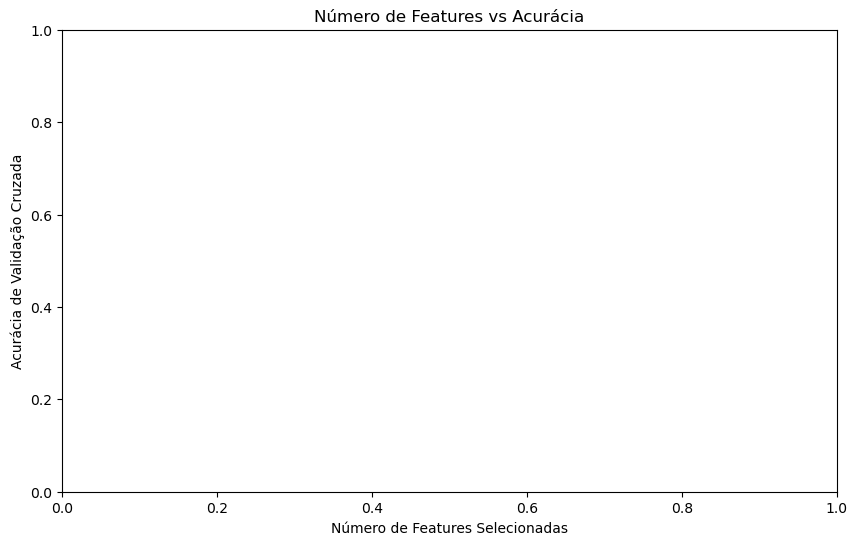

In [12]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Garantir que os índices de X e y estejam alinhados
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Definir o learning rate único
learning_rate = 0.5  # Você pode alterar este valor conforme necessário

# Pré-processamento
print("Realizando o pré-processamento...")
X_train, X_val = drop_description_columns(X_train, X_val)
X_train, X_val = preprocessing_dum(X_train, X_val)
X_train, X_val = scaling_encoding(X_train, X_val)
y_train, y_val = encoding_label(y_train, y_val)

# Seleção de features com RFECV
print("Selecionando features com RFECV...")
model_for_rfe = LogisticRegression(max_iter=1000)  # Modelo base para RFECV
cv_strategy = StratifiedKFold(n_splits=5)  # Estratégia de validação cruzada

rfecv = RFECV(estimator=model_for_rfe, step=1, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train, y_train)

selected_features = X_train.columns[rfecv.support_]
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

print(f"Número de features selecionadas: {len(selected_features)}")
print("Features selecionadas:", selected_features.tolist())

# Treinamento do modelo com as features selecionadas
print("Treinando o modelo...")
model = XGBClassifier(learning_rate=learning_rate, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_selected, y_train)

# Avaliação no conjunto de validação
print("Avaliando no conjunto de validação...")
y_pred_val = model.predict(X_val_selected)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')  # Use "weighted" para classes desbalanceadas

# Resultados
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

# Plotando o número de features vs desempenho
plt.figure(figsize=(10, 6))
plt.title('Número de Features vs Acurácia')
plt.xlabel('Número de Features Selecionadas')
plt.ylabel('Acurácia de Validação Cruzada')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [ ]:
val_f1 = f1_score(y_val, y_pred_val, average='macro')  
val_f1

0.378223164136909

c:\Users\inesm\OneDrive\Documentos\Mestrado\ML\Project\Preprocessing_functions.py:330: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(mean_value, inplace=True)
c:\Users\inesm\OneDrive\Documentos\Mestrado\ML\Project\Preprocessing_functions.py:331: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val[col].fillna(mean_value, inplace=True)
Selecionando features com RFECV...
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inesm\anaconda3\envs\DM2425\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:50:23] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
Número de features selecionadas: 9
Features selecionadas: ['Average Weekly Wage', 'C-2 Date', 'C-3 Date', 'First Hearing Date', 'IME-4 Count', 'Attorney/Representative_False', 'Attorney/Representative_True', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF']
Treinando o modelo...
Avaliando no conjunto de validação...
Validation Accuracy: 0.7765
Validation F1 Score: 0.7295


In [30]:
test_data = test_data[~(test_data.drop(columns=['Assembly Date']).isna().all(axis=1) & test_data['Assembly Date'].notna())] 

X_test = test_data
print(X_test.columns)

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'County of Injury', 'COVID-19 Indicator', 'District Name',
       'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code',
       'Industry Code Description', 'Medical Fee Region',
       'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Code',
       'WCIO Part Of Body Description', 'Zip Code', 'Number of Dependents'],
      dtype='object')


In [31]:
X_test, _ = drop_description_columns(X_test, X_val)
X_test, _ = preprocessing_dum(X_test, X_val)
X_test, _ = scaling_encoding(X_test, X_val)

c:\Users\inesm\OneDrive\Documentos\Mestrado\ML\Project\Preprocessing_functions.py:330: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(mean_value, inplace=True)
c:\Users\inesm\OneDrive\Documentos\Mestrado\ML\Project\Preprocessing_functions.py:331: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [32]:
y_pred_test = model.predict(X_test[selected_features])

In [35]:
enc2=LabelEncoder()
enc2.fit(y_train)

LabelEncoder()

In [36]:
test = enc2.inverse_transform(y_pred_test)
test

array(['4. TEMPORARY', '4. TEMPORARY', '2. NON-COMP', ..., '3. MED ONLY',
       '3. MED ONLY', '3. MED ONLY'], dtype=object)

In [37]:
## formating the submission file
X_test['Claim Injury Type'] = test
sample_submission = X_test[['Claim Injury Type']].set_index(X_test.index)
sample_submission.to_csv('submission_logistic regression_outliers.csv')